In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# generate plots of attention in order to see which parts of an image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

getting all annotations, also for coco cuz it has a big amount of annotations and words 

In [ ]:
''' in this block I am getting all annotations, captions of MSCOCO 2014 train val'''

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 830s 0us/step


The translated Image captions 

Reading captions using loop

In [ ]:
with open('train_captions_ar.txt' , 'r') as f:
  train_captions_ar = f.readlines()
  
with open('img_name_vector.txt' , 'r') as f:
  img_name_vector = f.readlines()
  

In [ ]:
#surround each caption with <start> and <end>
train_captions_ar = ['<start> '+ cap.replace('\n','') + ' <end>' for cap in train_captions_ar]
img_name_vector = [img_name.replace('\n','') for img_name in img_name_vector]

<start> زوجان يجلسان على مقعد خشبي.  <end>


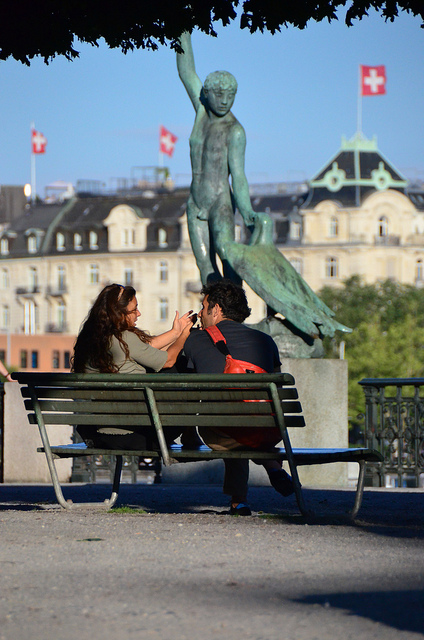

In [ ]:
#selecting a random image with caption
id = np.random.choice(range(len(train_captions_ar)))
print(train_captions_ar[id])

from IPython.display import Image
Image(img_name_vector[id])

Processing Image function

In [ ]:
def load_image(image_path):
  # reading Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #resize
    img = tf.image.resize(img, (224, 224))
    # processing it as the size of mobilenet
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
image_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                weights='imagenet', input_shape = (224, 224, 3))
# the line above using imagenet weights for the CNN model, used vgg pretrained version
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
# creating the model VGG for extracting features as the first step 
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

9412608/9406464 [==============================] - 0s 0us/step


Continuing of preprocessing 

In [ ]:
#getting the vector of names in sorted way
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  # reading imag, its vgg model
  batch_features = image_features_extract_model(img)
  #reshaping the features
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [ ]:
# the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,،-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions_ar)
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions_ar)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)



In [ ]:
#spliting dataset 80%-20% 
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

In [ ]:
#params

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
features_shape = 1280
attention_features_shape = 49
units = 256
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

def create_dataset(img_name, cap):
  dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))

 
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)


  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  
  return dataset 

In [ ]:
train_dataset = create_dataset(img_name_train, cap_train)
valid_dataset = create_dataset(img_name_val, cap_val)

Defining the model (a pretrained with with Transfer learning (changing the last layers)

In [ ]:
def get_encoder(embedding_dim):
    input = tf.keras.layers.Input((attention_features_shape, features_shape))
    # shape after fc == (batch_size, 49, embedding_dim)
    output = tf.keras.layers.Dense(embedding_dim, activation = "relu")(input)
    
    return tf.keras.models.Model(inputs = input, outputs = output)
  
# also using gru instead of bilstm and editing the last layers
def get_decoder(embedding_dim, units, vocab_size):
    gru = tf.keras.layers.GRU(units,
                   return_sequences=True,
                   return_state=True,
                   recurrent_initializer='glorot_uniform')

  
    #define the inputs to the decoder
    enc_output = tf.keras.layers.Input((attention_features_shape, embedding_dim))
    enc_hidden = tf.keras.layers.Input((embedding_dim,))
    dec_input = tf.keras.layers.Input((1,))
    
    hidden_with_time_axis = tf.keras.layers.Reshape((1, units))(enc_hidden)

    # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
    W1 = tf.keras.layers.Dense(units)
    W2 = tf.keras.layers.Dense(units)
    V  = tf.keras.layers.Dense(1)
    
    attention_weights = V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([W1(enc_output), W2(hidden_with_time_axis)])))
    attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(attention_weights))
    attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.keras.layers.Multiply()([attention_weights, enc_output])
    
    # reshape  
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    context_vector = tf.keras.layers.Dense(1)(context_vector)
    context_vector = tf.keras.layers.Permute((2, 1))(context_vector)
    
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(dec_input)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.keras.layers.Concatenate(axis = -1)([context_vector, x])
    # passing the concatenated vector to the GRU
    output, state = gru(x)
    
    output = tf.keras.layers.Dense(units)(output)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.keras.layers.Reshape((output.shape[2],))(output)

    # output shape == (batch_size * 1, vocab)
    x = tf.keras.layers.Dense(vocab_size)(output)

    return tf.keras.models.Model(inputs = [dec_input, enc_hidden, enc_output], outputs = [x, state])
    

In [ ]:
encoder = get_encoder(embedding_dim)

decoder = get_decoder(embedding_dim, units, vocab_size)

In [ ]:
#using Adam optimizer
optimizer = tf.keras.optimizers.Adam()
# for compile and loss we use categorical cross entropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# loss function returning the possible minimal loss 
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
# evaluation for an image
def evaluate(image):

    hidden = tf.zeros((1, units))
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder([dec_input, hidden, features])

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result
  
def predict():
  # captions of the validation set
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result = evaluate(image)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))

  return Image(img_name_val[rid])

Real Caption: <start> رجل يرتدي قميصًا رماديًا يطحن لوح التزلج أسفل سكة حديدية <end>
Prediction Caption: المطابقان وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور وصخور


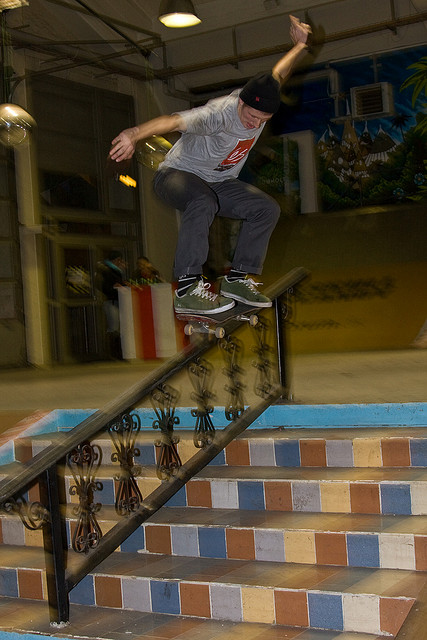

In [ ]:
predict()

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  #hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden = tf.zeros((target.shape[0], units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder([dec_input, hidden, features])

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

@tf.function
def valid_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  #hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden = tf.zeros((target.shape[0], units))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder([dec_input, hidden, features])

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  return loss, total_loss

In [ ]:

EPOCHS = 10

for epoch in range(0, EPOCHS):
    start = time.time()
    train_total_loss = 0
    valid_total_loss = 0 
    
    train_num_steps = 0 
    valid_num_steps = 0 

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        train_total_loss += t_loss
        train_num_steps += 1
        
    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        _, t_loss = valid_step(img_tensor, target)
        valid_total_loss += t_loss
        valid_num_steps += 1
        
    print ('Epoch {} train_Loss {:.2f} valid_Loss {:.2f}'.format(epoch + 1, train_total_loss/train_num_steps,
                                         valid_total_loss/valid_num_steps))
    predict()
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 train_Loss 1.36 valid_Loss 1.19
Real Caption: <start> المرأة تضرب كرة التنس <unk> <end>
Prediction Caption: رجل يقف على لوح التزلج <end>
Time taken for 1 epoch 1447.2202816009521 sec

Epoch 2 train_Loss 1.11 valid_Loss 1.06
Real Caption: <start> رجل يركب الزلاجات عبر أرض مغطاة بالثلوج <end>
Prediction Caption: رجل يقف على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح التزلج على لوح
Time taken for 1 epoch 1390.0302090644836 sec

Epoch 3 train_Loss 0.99 valid_Loss 0.99
Real Caption: <start> رجل يقف على ملعب تنس يحمل مضرب تنس <end>
Prediction Caption: رجل يرتدي قميصًا أحمر <end>
Time taken for 1 epoch 1386.7418031692505 sec

Epoch 4 train_Loss 0.91 valid_Loss 0.95
Real Caption: <start> سيارة تنتظر قطارًا <end>
Prediction Caption: قطار يسحب دراجة نارية في الشارع <end>
Time taken for 1 epoch 1382.3394577503204 sec

Epoch 5 train_Loss 0.86 valid_Loss 0.93
Real Caption: <start> 

Real Caption: <start> حشد كبير من الناس بالقرب من حافلة المدينة الكبيرة <end>
Prediction Caption: حافلة المدينة المزدحم مع العديد من الناس في أحد شوارع المدينة المزدحم <end>


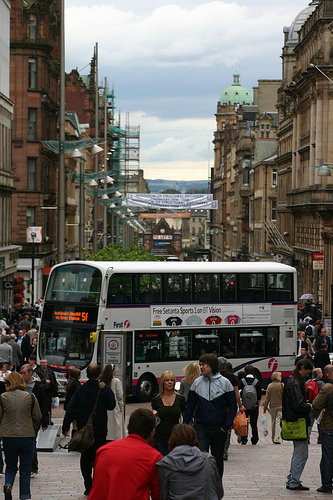

In [ ]:
predict()

In [ ]:
#attach the feature extraction model with the encoder
input = tf.keras.layers.Input((224, 224, 3))
x = image_model(input)
x = tf.keras.layers.Reshape((49, 1280))(x)
x = encoder(x)
attached = tf.keras.models.Model(inputs = input, outputs = x)

#save the encoder decoder
attached.save('encoder.h5')
decoder.save('decoder.h5')

In [ ]:
#save the dictionary
import csv
def create_csv(file, dict):
    with open(file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for key in dict.keys():
            writer.writerow([key,dict[key]])
create_csv('idx2word.csv', tokenizer.index_word)